# Text mining project 
## Checking the alignment of global actions and development targets
### Ivan Vallejo Vall, 19 June 2017

#### Jupyter notebook 3: *analysis.ipynb*

This notebook creates the charts and figures that address the research question. It requires the file "dictionaries.csv" (produced by the notebook *dictionaries.ipynb*) and the file "ITU_links_text.csv" (produced by the notebook *scrape.ipynb*) in the same directory. 

----
Code chunk 1:

* Requirements: python packages numpy, nltk, pandas, stop_words and sklearn. The file "ITU_links_text.csv" (produced by the notebook *scrape.ipynb*).
* Output: The tf-idf weighted document-term matrix of the ITU website corpus. 

In [3]:
# READ SCRAPED TEXT AND BUILD TF-IDF
import pandas as pd
import nltk as nl
import numpy as np
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
# Download corpora if necessary: nl.download()

# LOAD DATA OBTAINED BY SCRAPING
ITU_text = pd.read_csv("ITU_links_text.csv",sep='\t', encoding='utf-8', index_col=0)

#Processing of the data
stop_words = get_stop_words('en')
st = PorterStemmer()
docs = pd.Series(np.zeros(ITU_text.shape[0]))
tokens = [] #List of all words.

for i, line in enumerate(ITU_text['Text']):
    #Tokenize the data:
    doc_i = word_tokenize(line.lower())
    #Remove non-alphabetic characters:
    doc_i = [tok for tok in doc_i if tok.isalpha()]
    #Remove stopwords using a list of your choice:
    doc_i = [tok for tok in doc_i if tok not in stop_words]
    #Stem the data using the Porter stemmer:
    doc_i = [st.stem(tok) for tok in doc_i]

    tokens.extend(doc_i)
    docs.ix[i] = doc_i

result = []
for i in range(0,len(docs)):
    str1 = ' '.join(docs.ix[i])
    result.append(str1)

# Tf-idf
transformer = TfidfVectorizer(analyzer = 'word',tokenizer = word_tokenize,lowercase = True,stop_words = 'english',max_features=5000)
X_tfidf = transformer.fit_transform(result)
feature_names = transformer.get_feature_names()
dense = X_tfidf.todense()
denselist = dense.tolist()
# Convert to pandas for ease of operation
X = pd.DataFrame(denselist, columns=feature_names)

Code chunk 2:

* Requirements: python packages loaded in previous code chunks of this notebook. The file "dictionaries.csv" (produced by the notebook *dictionaries.ipynb*).
* Output: a dataframe with the results of applying the dictionaroes to the ITU website corpus. 

In [9]:
# APPLY ALL DICTIONARIES AND RECORD RESULTS

# Load dictionaries
test = pd.read_csv("dictionaries.csv",sep='\t',header=None, index_col=0)
dictionaries = np.array(test)

# Apply to corpus
results = pd.DataFrame(index=X.index.values,columns=["Dictionary "+str(1+i) for i in range(5)])
for i in range(5): 
    dic = X[[x for x in X.columns if x in dictionaries[i]]]
    results.ix[:,i] = np.array(dic.sum(axis=1)/X.values.sum())

maxs = results.idxmax(axis=1)
intsty = results.max(axis=1)
results["Main_topic"] = maxs
results["Intensity"] = intsty
results.ix[results["Intensity"]< 0.000001,5] = "None"

Code chunk 3:

* Requirements: python packages loaded in previous code chunks of this notebook + collections.
* Output: inline printed output on the webpages identified as more representative of each dictionary.

In [10]:
# OUT OF SAMPLE CHECKS: WEBSITES WITH THE HIGHEST INTENSITY FOR EACH TOPIC

from collections import Counter
webpages = []
first=[]

labels=['SDG4 (education)','SDG5 (gender)','SDG9 (infr.)','SDG14 (sea)','SDG17 (partnership)','None']

for i in range(5):
    pos = results[results['Main_topic'] == "Dictionary "+str(i+1)]['Intensity'].idxmax()
    first.append(pos)
    webpages.append(labels[i]+": http://www.itu.int"+np.str(ITU_text.iloc[pos][2]))
    a = [x for x in X.columns[X.iloc[pos,:]!=0] if x in dictionaries[i]]
    count = np.str(Counter(a))
    webpages.append("%s \n" %count[9:len(count)-2])
print("Websites with the highest intensity for each topic \n (i.e. whose content should correspond the most to the topic)\n")
print("\n".join(webpages))

Websites with the highest intensity for each topic 
 (i.e. whose content should correspond the most to the topic)

SDG4 (education): http://www.itu.int/en/sustainable-world/Pages/goal4.aspx
u'school': 1, u'engin': 1, u'person': 1, u'young': 1, u'decent': 1, u'safe': 1, u'primari': 1, u'divers': 1, u'indigen': 1, u'teacher': 1, u'train': 1, u'vocat': 1, u'suppli': 1, u'rural': 1, u'educ': 1, u'children': 1, u'expand': 1, u'standard': 1 

SDG5 (gender): http://www.itu.int/dms_pub/itu-s/opb/conf/S-CONF-PLEN-2015-TOC-HTM-E.htm
u'harm': 1, u'telephon': 1, u'enabl': 1, u'forc': 1, u'anoth': 1, u'empower': 1, u'legal': 1, u'union': 1, u'procedur': 1, u'respons': 1, u'document': 1, u'constitut': 1, u'provis': 1 

SDG9 (infr.): http://www.itu.int/en/sustainable-world/Pages/goal9.aspx
u'enterpris': 1, u'circumst': 1, u'chain': 1, u'credit': 1, u'alia': 1, u'drive': 1, u'landlock': 1, u'research': 1, u'capabl': 1, u'rais': 1, u'resili': 1, u'substanti': 1, u'african': 1, u'opportun': 1, u'industr

This makes sense, as each dictionary identified a webpage actually dedicated to explain that particular SDG. The only exception is gender, which pointed to a website listing the resolutions adopted in the last ITU plenipotentiary, several of them related to gender issues.

Code chunk 4:

* Requirements: python packages loaded in previous code chunks of this notebook (matplotlib reloaded, just in case) + plotly.
* Output: a figure with the histogrms of the intensity of each topic for all websites classified as being predominantly related to that topic.

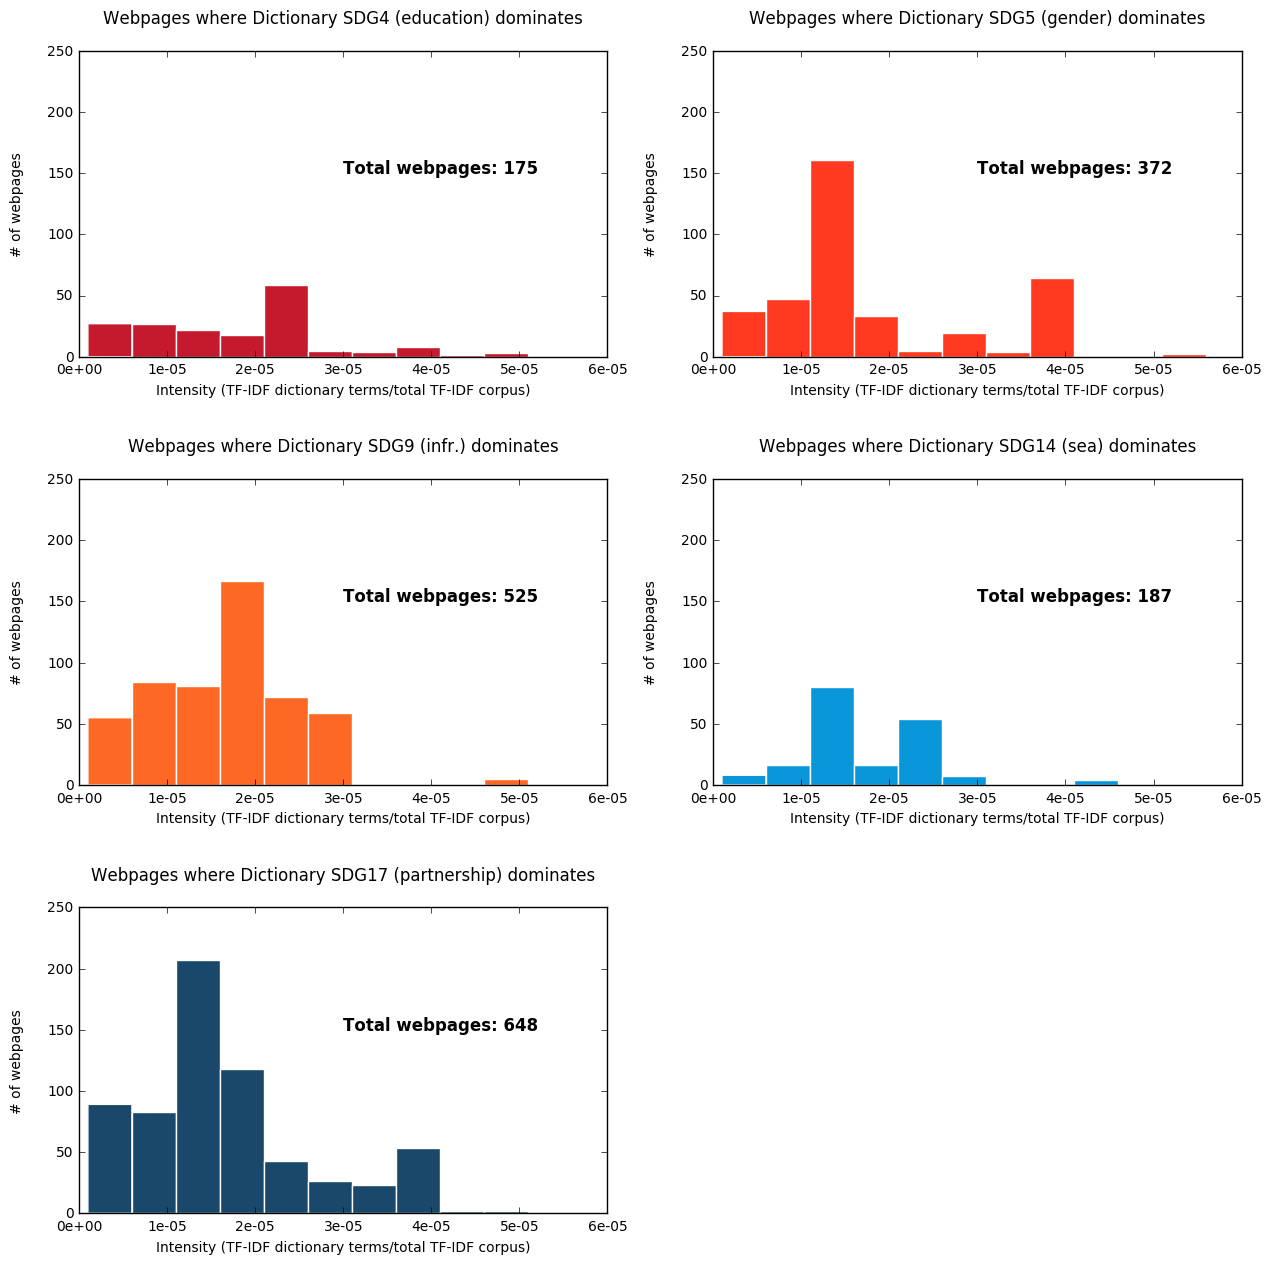

In [11]:
# PLOT SOME RESULTS - HISTOGRAMS
import matplotlib.pyplot as plt
import plotly.plotly as py
import matplotlib.ticker as mtick

fig, ax = plt.subplots(3,2, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)
nbin=np.arange(0.000001,0.00006,0.000005)
col=['#c5192d','#ff3a21','#fd6925','#0A97d9','#19486a','#d3d3d3']
labels=['SDG4 (education)','SDG5 (gender)','SDG9 (infr.)','SDG14 (sea)','SDG17 (partnership)','None']

# first plot
xs = np.array(results[results["Main_topic"]=="Dictionary 1"]["Intensity"])
ax[0,0].hist(xs,edgecolor="w",color=col[0],bins=nbin)
ax[0,0].set_ylim([0,250])
ax[0,0].set_title("Webpages where Dictionary %s dominates\n" %labels[0])
ax[0,0].set_xlabel("Intensity (TF-IDF dictionary terms/total TF-IDF corpus)")
ax[0,0].set_ylabel("# of webpages\n")
ax[0,0].annotate('Total webpages: %d' %len(xs) , xy=(0.00003,150),size=12,weight='bold')
ax[0,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# second plot
xs = np.array(results[results["Main_topic"]=="Dictionary 2"]["Intensity"])
ax[0,1].hist(xs,edgecolor="w",color=col[1],bins=nbin)
ax[0,1].set_ylim([0,250])
ax[0,1].set_title("Webpages where Dictionary %s dominates\n" %labels[1])
ax[0,1].set_xlabel("Intensity (TF-IDF dictionary terms/total TF-IDF corpus)")
ax[0,1].set_ylabel("# of webpages\n")
ax[0,1].annotate('Total webpages: %d' %len(xs) , xy=(0.00003,150),size=12,weight='bold')
ax[0,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# third plot
xs = np.array(results[results["Main_topic"]=="Dictionary 3"]["Intensity"])
ax[1,0].hist(xs,edgecolor="w",color=col[2],bins=nbin)
ax[1,0].set_ylim([0,250])
ax[1,0].set_title("Webpages where Dictionary %s dominates\n" %labels[2])
ax[1,0].set_xlabel("Intensity (TF-IDF dictionary terms/total TF-IDF corpus)\n")
ax[1,0].set_ylabel("# of webpages\n")
ax[1,0].annotate('Total webpages: %d' %len(xs) , xy=(0.00003,150),size=12,weight='bold')
ax[1,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# fourth plot
xs = np.array(results[results["Main_topic"]=="Dictionary 4"]["Intensity"])
ax[1,1].hist(xs,edgecolor="w",color=col[3],bins=nbin)
ax[1,1].set_ylim([0,250])
ax[1,1].set_title("Webpages where Dictionary %s dominates\n" %labels[3])
ax[1,1].set_xlabel("Intensity (TF-IDF dictionary terms/total TF-IDF corpus)\n")
ax[1,1].set_ylabel("# of webpages\n")
ax[1,1].annotate('Total webpages: %d' %len(xs) , xy=(0.00003,150),size=12,weight='bold')
ax[1,1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# fifth plot
xs = np.array(results[results["Main_topic"]=="Dictionary 5"]["Intensity"])
ax[2,0].hist(xs,edgecolor="w",color=col[4],bins=nbin)
ax[2,0].set_ylim([0,250])
ax[2,0].set_title("Webpages where Dictionary %s dominates\n" %labels[4])
ax[2,0].set_xlabel("Intensity (TF-IDF dictionary terms/total TF-IDF corpus)\n")
ax[2,0].set_ylabel("# of webpages\n")
ax[2,0].annotate('Total webpages: %d' %len(xs) , xy=(0.00003,150),size=12,weight='bold')
ax[2,0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

ax[2,1].axis("off")

plt.show() # TO SAVE IT REPLACE WITH plt.savefig('Histograms_topics.pdf')

Code chunk 5:

* Requirements: python packages loaded in previous code chunks of this notebook.
* Output: a figure with the pie charts of the distribution of topics broken down by depth level.

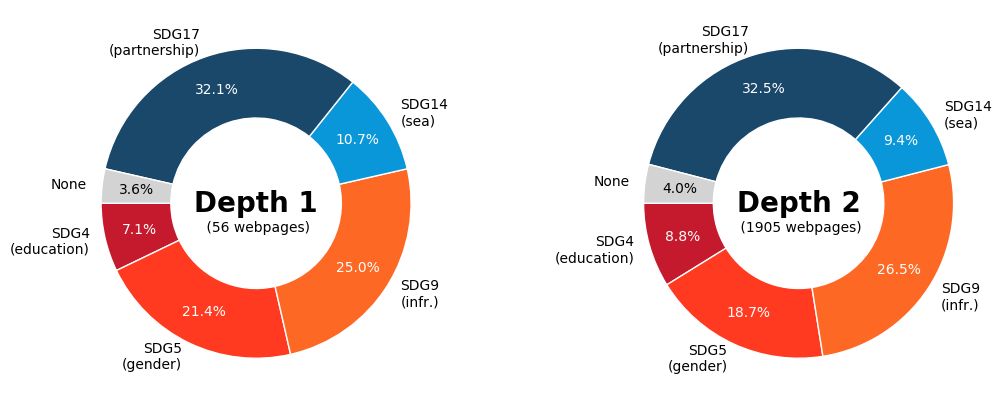

In [14]:
# PLOT SOME RESULTS - DONUTS

#Get data
results['depth']=ITU_text['depth']
donut1=results.ix[results['depth']==1,5:7].groupby('Main_topic').count()
donut2=results.ix[results['depth']==2,5:7].groupby('Main_topic').count()

#Format labels to make them shorter
short_labels=np.zeros(6,dtype='object')
for i,lab in enumerate(labels):
    if i != 5:
        pos=lab.find(' ')
        short_labels[i]= lab[:pos]+"\n"+lab[pos+1:]
    else:
        short_labels[i]=lab

#Create and adjsut plot grid
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
plt.subplots_adjust(wspace=0.4)

#Draw 1st donut
ax1.axis('equal')
width = 0.45
kwargs = dict(colors=col, startangle=180,pctdistance=1-width/2,autopct='%1.1f%%')
outside, _, autotexts = ax1.pie(donut1['Intensity'].values, radius=1, labels=short_labels,**kwargs)
for i,autotext in enumerate(autotexts):
    if i !=5:
        autotext.set_color('white')
plt.setp( outside, width=width, edgecolor='white')
kwargs = dict(size=20, fontweight='bold', va='center')
ax1.text(0, 0, "Depth 1", ha='center', **kwargs)
ax1.text(0, 0, "\n\n\n (%d webpages)" %donut1.sum()[0], ha='center', size=10,va='center')

#Draw 2nd donut
ax2.axis('equal')
width = 0.45
kwargs = dict(colors=col, startangle=180,pctdistance=1-width/2,autopct='%1.1f%%')
outside, _, autotexts = ax2.pie(donut2['Intensity'].values, radius=1, labels=short_labels,**kwargs)
for i,autotext in enumerate(autotexts):
    if i !=5:
        autotext.set_color('white')
plt.setp( outside, width=width, edgecolor='white')
kwargs = dict(size=20, fontweight='bold', va='center')
ax2.text(0, 0, "Depth 2", ha='center', **kwargs)
ax2.text(0, 0, "\n\n\n (%d webpages)" %donut2.sum()[0], ha='center', size=10,va='center')

plt.show()  # TO SAVE IT REPLACE WITH plt.savefig('donuts.pdf',bbox_inches='tight')

Code chunk 6:

* Requirements: python packages loaded in previous code chunks of this notebook (matplotlib and numpy reloaded, just in case) + igraph and random. I installed igraph without problems in an instance, had some difficulties in my computer. It requires "cairo", a graphic management library. For some reason I did not have it correctly installed in my py2 environment, and it took me some time to locate it and add it to the pythonpath of my virtual environment.  
* Output: a network diagram showing the graph of the ITU website connections colored according to the topic classification of each webpage.

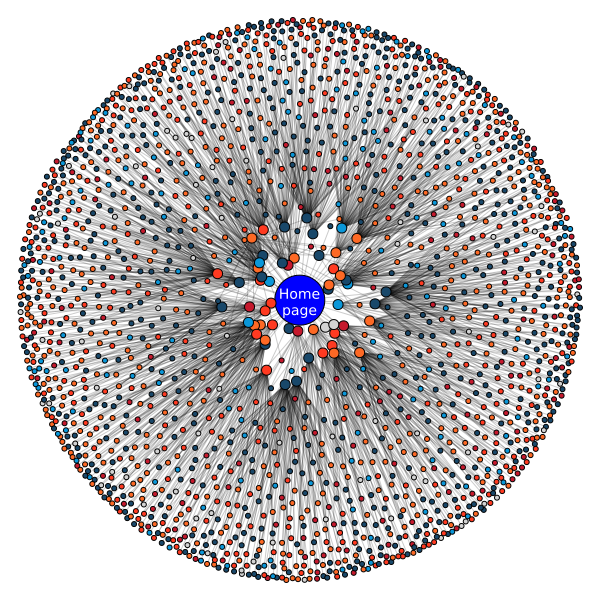

In [175]:
# PLOT SOME RESULTS - NETWORK GRAPH

import igraph as ig # requires igraph: sudo pip install python-igraph 
# igraph also requires cairo graphic library, in instance was already installed, not in my computer
import matplotlib.pyplot as plt
import numpy as np
import random


# combine network data and dictionary results
ITU_text['Main_topic'] = np.array(results['Main_topic'])
ITU_text['Intensity'] = np.array(results['Intensity'])
# we have some blanks in the IDs because we filtered at the end of the scrape script
# the webpages with too few rows -> we need to reset ids to make the graph rendering nice
ITU_text['new_id']= range(len(results))
id_change = dict(zip(ITU_text.id, ITU_text.new_id))
id_change[-1]=-1


# create color scale    
color_scale = { 'Dictionary 1' : col[0], 'Dictionary 2' : col[1],'Dictionary 3':col[2],'Dictionary 4':col[3],
              'Dictionary 5':col[4],'None':col[5],np.nan:col[5]}

## PLOT GRAPH ALL ITU WEBPAGES DEPTH 1 and 2
links = []
colors = []
sizes = []
depth= []

# BUILD LIST OF EDGES & NODES
# initial node properties (ITU Home page)
colors.append("blue")
sizes.append(50)
depth.append(0)
#subsequent nodes/links
for row in ITU_text.itertuples():
    if row[1]<3:
        links.append((id_change[int(row[4])]+1,id_change[int(row[2])]+1))
        depth.append(row[1])
        if row[1] == 1:
            colors.append(color_scale[row[6]])
            sizes.append(10)
        elif row[1] == 2:
            colors.append(color_scale[row[6]])
            sizes.append(5)
nodes = list(range(len(links)+1))

# CREATE GRAPH
g = ig.Graph()
g.add_vertices(len(nodes))
g.add_edges(links)
g.vs['color']=colors
g.vs['depth'] = depth
g.vs['size']=sizes
random.seed(110)
layout = g.layout("kk")
g.vs[0]['label']="Home\npage"
g.vs[0]['label_color']="white"

# # ensure no overlapping with initial node
for i, dot in enumerate(layout):
    if i != 0 and abs(dot[0]-layout[0][0]) < 0.3 and abs(dot[1]-layout[0][1]) < 0.3:
        k=min(abs(0.4/(0.01+dot[0]-layout[0][0])),
                 abs((0.4/(0.01+dot[1]-layout[0][1]))))
        layout[i] = list([layout[0][0]+k*(dot[0]-layout[0][0]),layout[0][1]+k*(dot[1]-layout[0][1])])

ig.plot(g, "ITU_links_graph_final.pdf", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_graph_final.svg", layout = layout, edge_color="rgba(1,1,1,0.2)")
ig.plot(g, "ITU_links_graph_final.png", layout = layout, edge_color="rgba(1,1,1,0.2)")
